### Importing data and discovering it

In [6]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
fetch_housing_data()

In [7]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [8]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [9]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

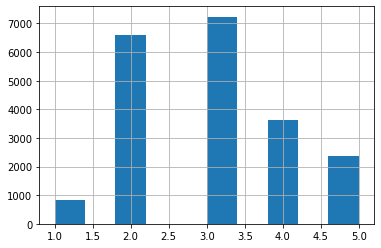

In [10]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace=True)
housing['income_cat'].hist()

### Splitting data to train/test splits

In [11]:
#stratified split by housing_income variable
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [12]:
housing = strat_train_set.copy()

In [13]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

In [14]:
#Custom transformer to be called later in full_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X,y = None):
        return self
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [15]:
#numerical attributes pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributeAdder()),
    ('std_scaler', StandardScaler()),
])

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

### Select and train a model 

In [53]:
from sklearn.svm import SVR

In [54]:
svm_model = SVR()
svm_model.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [56]:
from sklearn.metrics import mean_squared_error

housing_predictions = svm_model.predict(housing_prepared)
svm_mse = mean_squared_error(housing_predictions, housing_labels)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

118580.68301157995

### Model Finetuning

#### GridSearchCV

In [57]:
from sklearn.model_selection import GridSearchCV
import time
param_grid = [
    {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

grid_search = GridSearchCV(svm_model, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
tic = time.clock()
grid_search.fit(housing_prepared, housing_labels)
toc=time.clock()
print(f'fitting took {(toc-tic)/60} min')

fitting took 65.38563556666665 min


In [58]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [59]:
grid_search.best_estimator_

SVR(C=30000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [60]:
#show results
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score), params)

84654.24944894915 {'C': 10.0, 'kernel': 'linear'}
75448.97722080236 {'C': 30.0, 'kernel': 'linear'}
71603.17710755806 {'C': 100.0, 'kernel': 'linear'}
70703.96434485051 {'C': 300.0, 'kernel': 'linear'}
70445.3835347414 {'C': 1000.0, 'kernel': 'linear'}
70395.04242174576 {'C': 3000.0, 'kernel': 'linear'}
70374.76833985467 {'C': 10000.0, 'kernel': 'linear'}
70363.84006944533 {'C': 30000.0, 'kernel': 'linear'}
118810.30512885563 {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
118692.99130284463 {'C': 1.0, 'gamma': 0.03, 'kernel': 'rbf'}
118638.14057023903 {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
118768.3401960818 {'C': 1.0, 'gamma': 0.3, 'kernel': 'rbf'}
118886.58611084612 {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
118916.21318237013 {'C': 1.0, 'gamma': 3.0, 'kernel': 'rbf'}
118596.16891020472 {'C': 3.0, 'gamma': 0.01, 'kernel': 'rbf'}
118256.54516476246 {'C': 3.0, 'gamma': 0.03, 'kernel': 'rbf'}
118077.86879656409 {'C': 3.0, 'gamma': 0.1, 'kernel': 'rbf'}
118460.90805382353 {'C': 3.0, 'gamma'

#### RandomizedSearchCV

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
import time

#gamma ignored when using linear kernel
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

rand_search = RandomizedSearchCV(svm_model, param_distribs,n_iter=50, cv=5,
                          scoring='neg_mean_squared_error',verbose=2,random_state=42,
                          return_train_score=True)
tic = time.clock()
rand_search.fit(housing_prepared, housing_labels)
toc = time.clock()
print(f'training took {(toc-tic)/60} min')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.7s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.7s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.3s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.1s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.1min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  50.2s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.0min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  54.5s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  43.1s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.1s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.3

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   6.7s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  35.3s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  34.2s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  53.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  36.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  29.5s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=   

[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  23.5s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  22.3s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  10.5s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  10.6s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  10.5s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  10.5s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  10.5s
[CV] C=399.7268155705

[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   6.6s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   6.5s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   6.4s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  10.5s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  10.5s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  10.5s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  10.5s
[CV] C=2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 80.8min finished


training took 81.48692858333334 min


In [64]:
rand_search.best_estimator_

SVR(C=157055.10989448498, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

### Evaluating the model on the Test set

In [61]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
# transform the test data using full_pipeline.transform() and not fit_transform() because we don't want to fit the test set
X_test_prepared = full_pipeline.transform(X_test)
#predict
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

68139.43891327262

In [65]:
final_model = rand_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
# transform the test data using full_pipeline.transform() and not fit_transform() because we don't want to fit the test set
X_test_prepared = full_pipeline.transform(X_test)
#predict
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

52490.03793898214